In [3]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

# Aim
This notebook aims at better understanding the paper from Yang and Chan [PDA J Pharm Sci and Tech 2013, 67 601-609](http://journal.pda.org/lookup/doi/10.5731/pdajpst.2013.00942) and re-implement their approach in Python.

# Background

The abstract from the paper describes quite nicely the new risk based approach for testing bioburden fitrations as suggested by EMA:

>Microbial control during the drug substance and drug product manufacturing process is critical for ensuring product quality and safety. For sterile biological drug products (finished dosage forms) typically manufactured by sterile filtration followed by aseptic processing, control of the microbial load at the sterile filtration step is an important component of the overall microbial control strategy. Both FDA and EMA regulatory guidelines stipulate that a maximum acceptable bioburden level, which is referred to as a pre-filtration bioburden level in this paper, should be stated at the point immediately prior to the sterile filtration step. The EMA guideline further states that a bioburden limit of no more than 10 colony-forming units (CFU) per 100 mL will be considered acceptable in most situations. The EMA guideline also states that a pre-filtration sample volume of less than 100 mL may be tested if
justified. This paper introduces a risk-based method to establish pre-filtration bioburden acceptance levels and alternative test volumes. The relationship between bioburden risk, pre-filtration bioburden test limits, and sterile filtration process parameters, such as filtration volume, filter surface area, and microbial retention capacity of the sterilizing filter, was statistically determined. Taking into account the batch filtration volume, it is shown that pre-filtration bioburden test volumes and acceptance limits other than 10 CFU/100 mL may be justified, without compromise to sterility assurance. [Yang and Chan]

## Figure 1

Following scenario is considered:

- The true CFU count of a solution is 11 CFU / 100 mL
- The assay variability is 22 which resembles to a standard deviation of 4.7 CFU/100 mL
- The upper acceptance limit is 10 CFU / 100 mL

Following the paper, a negative binomial distribution is assumed for the data. Scipy`s implementation of the distribution requires reformulation of the parameters as described in the [online documenation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.nbinom.html) and shown below:

In [10]:
# the (assumed) true mean
mu = 11 # CFU/100mL

# the variation of the assay
var = 2*mu

# the upper accepance limit
ual = 10  # upper acceptance limit'

# the negative binomial distribution 
p = mu / var
n = mu * p / (1-p)
nb = stats.nbinom(n=n, p=p)

11 22 0.5 11.0


Text(0.5, 1.0, 'True mean: 11, Variance: 22')

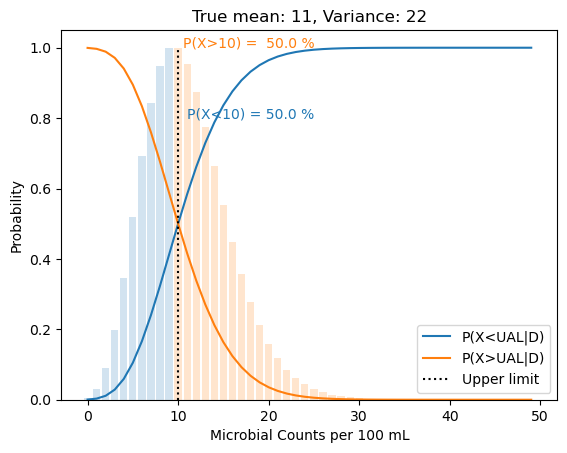

In [6]:
"""
This figure does not aresemble the figure from the paper to 100 % although it yields the same result. I like this representation more.
This figure answers: z.B. P(X<UAL|D, ual) with varying UAL and fixed y axis. The figure showes 1-CDF als acceptance probability although
the CDF is used to calculate P(X<UAL|D) which is more intuitive (for non statistical thinker) and misleading (when implementing it)
at the same time.
This figure shows the probability of observing X>UAL when sampled from the underlying distribution. 
The figure in the paper answers the question, what is the probability of accepting a batch upon observing X. Whis is odd in my opinion.
"""

# CFU/100 mL on the x axis
xhat = np.arange(0,50)

# the probability of observing values below xhat for the given distribution
yhat = nb.cdf(xhat)
yhat1 = nb.sf(xhat)
x0 = xhat[xhat<ual]
x1 = xhat[xhat>=ual]
yd0 = nb.pmf(x0)
yd1 = nb.pmf(x1)
yd = nb.pmf(xhat)

plt.plot(xhat, yhat, label='P(X<UAL|D)')
plt.plot(xhat, yhat1, label='P(X>UAL|D)')
#plt.plot(xhat, 1-yhat1, label='1-sf')
#plt.bar(xhat, yd/yd.max(), alpha=0.2)
plt.bar(x0, yd0/yd0.max(), alpha=0.2)
plt.bar(x1, yd1/yd0.max(), alpha=0.2)
plt.vlines(ymin=0, ymax=1, x=ual, color='black', linestyle=':', label='Upper limit')
plt.text(x=ual*1.1, y=0.8, 
         s=f'P(X<{ual:0.0f}) = {nb.cdf(ual)*100:0.1f} %',
         color='C0')
plt.text(x=ual*1.05, y=max(yd1/yd0.max()), 
         s=f'P(X>{ual:0.0f}) =  {nb.sf(ual)*100:0.1f} %', 
         color='C1')

plt.legend(loc='best')
plt.xlabel('Microbial Counts per 100 mL')
plt.ylabel('Probability')
plt.title(f'True mean: {mu}, Variance: {var}')

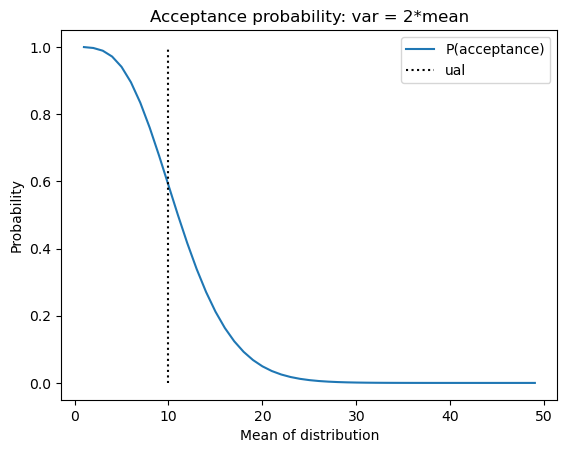

In [7]:
"""
This plot resembles figure 1
"""
# plot the probability of acceptance for various means
mu_list = np.arange(1,50)  # CFU/100mL
p_acc_list = []
for mu in mu_list:
    var = 2*mu
    ual = 10  # upper acceptance limit'

    p = mu / var
    n = mu * p / (1-p)


    nb = stats.nbinom(n=n, p=p)
    p_acc_list.append(nb.cdf(ual))
    
plt.plot(mu_list, p_acc_list, label='P(acceptance)')
plt.vlines(x=ual, ymin=0, ymax=1, linestyle=':', color='k', label='ual')
plt.title('Acceptance probability: var = 2*mean')
plt.ylabel('Probability')
plt.xlabel('Mean of distribution')
plt.legend(loc=1)

# Figure 2

Text(0.5, 1.0, 'True mean: 10 CFU/100mL, Variance=2*mean')

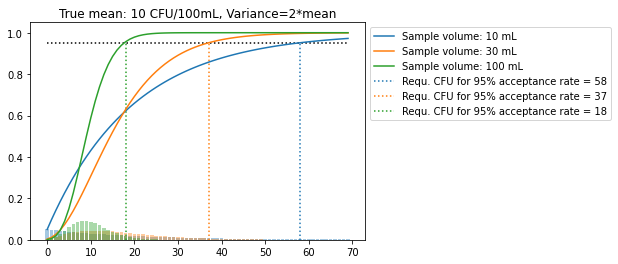

In [14]:
"""
This figure is an alternative representation to those from the paper. 
It tries to resemble Figure 7.6 from the Book "Emerging Non-Clinical Biostatistics in Biopharmaceutical Development and Manufacturing"
However, the probabilities are not the same. The book yields 63, 32, 20 CFUs for 95% detection probability.
I am not sure, if adapting p is the proper choice.
"""
volumes = np.array([10, 30, 100])  # mL
ual = np.array([1, 3, 10])  # MCU/100mL

mu = 10
var = 2*mu
# reparameterize to match scipy's nb function
p = mu / var
n = mu**2 / (var - mu)  # equivalent to n = mu * p / (1-p)
    
fix, ax = plt.subplots(ncols=1)
xhat = np.arange(0,70)
#xhat = np.linspace(0, 70, 100)

for i, vol in enumerate(volumes):
    p_adj = p*vol/100
    nb = stats.nbinom(n=ual[i], p=p_adj)
    ax.plot(xhat, nb.cdf(xhat), label=f'Sample volume: {vol} mL', color=plt.cm.tab10(i))
    #ax.plot(xhat, nb.sf(xhat), color=plt.cm.tab10(i), linestyle='--', label=f'sample volume: {volumes[i]}')
    ax.vlines(ymin=0, 
              ymax=nb.cdf(nb.ppf(0.95)), 
              x=nb.ppf(0.95), 
              color=plt.cm.tab10(i), 
              linestyle=':' , 
              label=f'Requ. CFU for 95% acceptance rate = {nb.ppf(0.95):0.0f}')
    ax.bar(xhat, nb.pmf(xhat), alpha=0.4)

ax.hlines(xmin=xhat[0], xmax=xhat[-1], y=0.95, linestyle=':', color='k')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title(f'True mean: 10 CFU/100mL, Variance=2*mean')

Text(0, 0.5, 'Probability of acceptance')

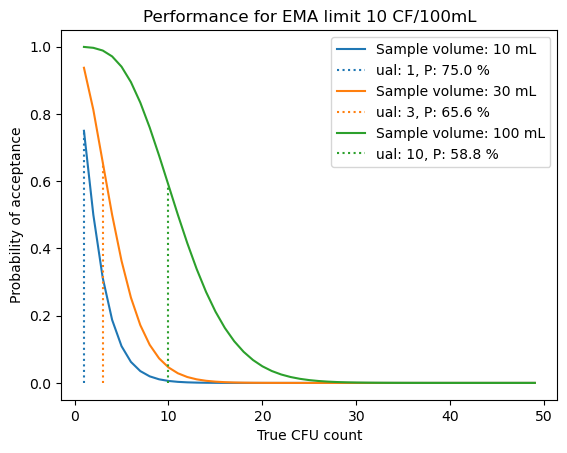

In [8]:
"""
This figure is an alternative representation to those from the paper. Results match those from the paper.
I do not like the representation. It is not intuitive to my understanding.
"""
volumes = np.array([10, 30, 100])  # mL
ual = np.array([1, 3, 10])  # MCU/100mL
    
fix, ax = plt.subplots(ncols=1)
xhat = np.arange(1,50)
#xhat = np.linspace(0, 70, 100)
true_mu = 10  # CFU/100mL
var = 2*true_mu
for i, vol in enumerate(volumes):
    p_acc_list = []
    for mu in xhat:
        var = 2*mu
        # reparameterize to match scipy's nb function
        p = mu / var
        n = mu**2 / (var - mu)  # equivalent to n = mu * p / (1-p)
        p_adj = p*vol/100
        p_adj = p
        nb = stats.nbinom(n=n, p=p_adj)
        p_acc_list.append(nb.cdf(ual[i]))
        
    ax.plot(xhat, p_acc_list, label=f'Sample volume: {vol} mL', color=plt.cm.tab10(i))
    #ax.bar(xhat, nb.pmf(xhat), alpha=0.4)
    #ax.plot(xhat, nb.sf(xhat), color=plt.cm.tab10(i), linestyle='--', label=f'sample volume: {volumes[i]}')
    mu = ual[i]
    var = 2*mu
    # reparameterize to match scipy's nb function
    p = mu / var
    n = mu**2 / (var - mu)  # equivalent to n = mu * p / (1-p)
    nb = stats.nbinom(n=n, p=p)
    p = nb.cdf(ual[i])
    ax.vlines(ymin=0, 
              ymax=p, 
              x=ual[i], 
              color=plt.cm.tab10(i), 
              linestyle=':' , 
              label=f'ual: {ual[i]}, P: {p*100:0.1f} %')
ax.legend(loc=1)
ax.set_title('Performance for EMA limit 10 CF/100mL')
ax.set_xlabel('True CFU count')
ax.set_ylabel('Probability of acceptance')

Text(0, 0.5, 'Probability of acceptance')

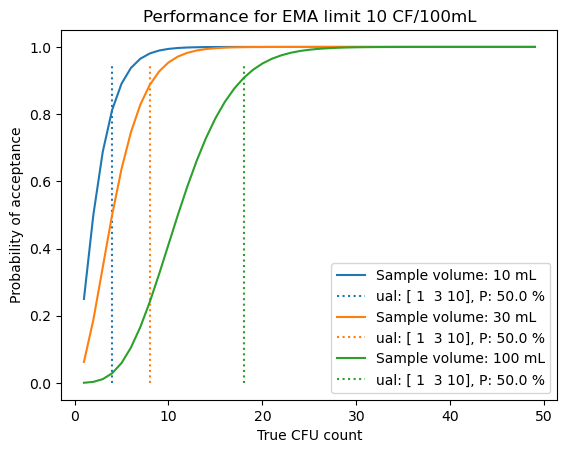

In [9]:
"""

"""
volumes = np.array([10, 30, 100])  # mL
ual = np.array([1, 3, 10])  # MCU/100mL
    
fix, ax = plt.subplots(ncols=1)
xhat = np.arange(1,50)
#xhat = np.linspace(0, 70, 100)
true_mu = 10  # CFU/100mL
var = 2*true_mu
for i, vol in enumerate(volumes):
    p_acc_list = []
    for mu in xhat:
        var = 2*mu
        # reparameterize to match scipy's nb function
        p = mu / var
        n = mu**2 / (var - mu)  # equivalent to n = mu * p / (1-p)
        nb = stats.nbinom(n=n, p=p)
        p_acc_list.append(1-nb.cdf(ual[i]))
        
    ax.plot(xhat, p_acc_list, label=f'Sample volume: {vol} mL', color=plt.cm.tab10(i))
    #ax.bar(xhat, nb.pmf(xhat), alpha=0.4)
    #ax.plot(xhat, nb.sf(xhat), color=plt.cm.tab10(i), linestyle='--', label=f'sample volume: {volumes[i]}')
    mu = ual[i]
    var = 2*mu
    # reparameterize to match scipy's nb function
    p = mu / var
    n = mu**2 / (var - mu)  # equivalent to n = mu * p / (1-p)
    nb = stats.nbinom(n=n, p=p)
    x = nb.ppf(0.95)
    ax.vlines(ymin=0, 
              ymax=0.95, 
              x=x, 
              color=plt.cm.tab10(i), 
              linestyle=':' , 
              label=f'ual: {ual}, P: {p*100:0.1f} %')
ax.legend(loc='best')
ax.set_title('Performance for EMA limit 10 CF/100mL')
ax.set_xlabel('True CFU count')
ax.set_ylabel('Probability of acceptance')